In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import glob
sys.path.append('/home/jleland/Coding/Projects/flopter')
import magopter as mg
import constants as c
import databases.magnum as mdb
import normalisation as nrm
import lputils as lp
import classes.ivdata as ivd
import filtering as filt
import scipy.signal as sig
import fitters as fts

In [3]:
folders = ['2018-05-01_Leland/', '2018-05-02_Leland/', '2018-05-03_Leland/',
           '2018-06-05_Leland/', '2018-06-06_Leland/', '2018-06-07_Leland/']
files = []
file_folders = []
for folder1 in folders:
    os.chdir(mg.Magopter.get_data_path() + folder1)
    files.extend(glob.glob('*.adc'))
    file_folders.extend([folder1] * len(glob.glob('*.adc')))
files.sort()

# file = files[286]
file = files[285]
ts_file = files[284]
folder = file_folders[-2]
print('"{}" \t\t "{}" \t\t "{}"'.format(folder, file, ts_file))

mp = lp.MagnumProbes()

"2018-06-07_Leland/" 		 "2018-06-07 14h 38m 33s TT_06564321037878221702.adc" 		 "2018-06-07 14h 33m 45s TT_06564319866763108260.adc"


In [9]:
probe_0 = mp.probe_s

In [10]:
dsr = 1

# Create magopter object
magopter = mg.Magopter(folder, file, ts_filename=ts_file)
magopter.prepare(down_sampling_rate=dsr, roi_b_plasma=True, plot_fl=False, crit_freq=None, crit_ampl=None)

print('0: {}, 1: {}'.format(len(magopter.iv_arrs[0]), len(magopter.iv_arrs[1])))

# Take index of midpoint of array, then throw away all but 3 consecutive IV curves from that index. 
index = int(0.5 * len(magopter.iv_arrs[0]))
magopter.iv_arrs[0] = magopter.iv_arrs[0][index:index + 3]
magopter.iv_arrs[1] = []

# magopter.trim(trim_beg=0.05, trim_end=0.7)
fit_df_0, fit_df_1 = magopter.fit(print_fl=True)

# Get values for TS measurements, depending on whether Magnum database is available.
if magopter.ts_temp is not None:
    temps = [np.max(temp) / nrm.ELEM_CHARGE for temp in magopter.ts_temp[mdb.DATA]]
    denss = [np.max(dens) for dens in magopter.ts_dens[mdb.DATA]]
    T_e_ts = np.mean(temps)
    d_T_e_ts = np.std(temps) / np.sqrt(len(temps))
    n_e_ts = np.mean(denss)
    d_n_e_ts = np.std(denss) / np.sqrt(len(denss))
else:
    T_e_ts = 1.61
    d_T_e_ts = 0.01
    n_e_ts = 1.4e20
    d_n_e_ts = 0.1e20

count = fit_df_0[c.ELEC_TEMP].count()

Start Time:  13:38:12
End Time:  13:38:52
Beam Down Timestamp:  6564321041100203608 1528375093.15
Regular Timestamp:  6564321037878221702 1528375092.399824


/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


peaks_len = 398
0: 398, 1: 398


In [11]:
for iv_arr in magopter.iv_arrs[0]:
    print(type(iv_arr))
    
iv_indices = list(range(3))
print(iv_indices)

<class 'classes.ivdata.IVData'>
<class 'classes.ivdata.IVData'>
<class 'classes.ivdata.IVData'>
[0, 1, 2]


In [12]:
iv_datas = [fit_df_0.iloc[[iv_index]] for iv_index in iv_indices]
print('count={}, 0={}, 1={}, 2={}'.format(count, *iv_indices))

alpha = 9.95
theta_perp = np.radians(alpha)
d_theta_perp = np.radians(0.8)
A_coll_0 = probe_0.get_collection_area(theta_perp)
d_A_coll = np.abs(probe_0.get_collection_area(theta_perp + d_theta_perp) - A_coll_0)

# deg_freedom = 2
# gamma_i = (deg_freedom + 2) / 2
gamma_i = 1
c_s = np.sqrt((nrm.ELEM_CHARGE * (fit_df_0[c.ELEC_TEMP] + gamma_i * fit_df_0[c.ELEC_TEMP])) / nrm.PROTON_MASS)
d_c_s = np.abs((c_s * fit_df_0[c.ERROR_STRING.format(c.ELEC_TEMP)]) / (2 * fit_df_0[c.ELEC_TEMP]))

n_e = fit_df_0[c.ION_SAT] / (nrm.ELEM_CHARGE * c_s * A_coll_0)
d_n_e = np.abs(n_e) * np.sqrt((d_c_s / c_s) ** 2 + (d_A_coll / A_coll_0) ** 2 
                              + (fit_df_0[c.ERROR_STRING.format(c.ION_SAT)] / fit_df_0[c.ION_SAT]) ** 2)

count=3, 0=0, 1=1, 2=2


iv = 0: 
	 v_f = -13.3 +- 0.05 
	 T_e = 6.34 +- 0.1 
	 I_sat = 1.11 +- 0.007 
	 n_e = 7.21e+19 +- 5e+18 
	 a = 0.000464 +- 0.001 
	 c_s = 3.49e+04 +- 3e+02 
	 A_coll = 2.75e-06 +- 2e-07 

a = 0.004583098955195815, c_s = 34863.24964229407, lambda_d = 2.204860263290826e-06, I_0 = 1.1073429548333338
a = 0.00165323075130103, c_s = 17582.941645962666, lambda_d = 7.953445529387089e-07, I_0 = 1.0917034253527582


<IPython.core.display.Javascript object>


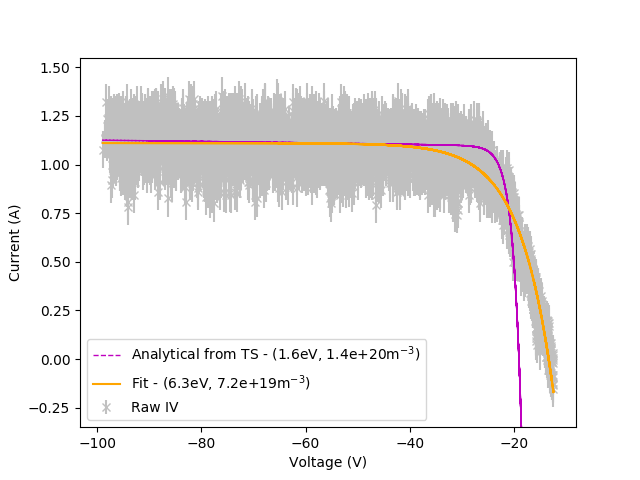

iv = 1: 
	 v_f = -13.2 +- 0.05 
	 T_e = 5.93 +- 0.1 
	 I_sat = 1.11 +- 0.007 
	 n_e = 7.51e+19 +- 5e+18 
	 a = 0.00377 +- 0.001 
	 c_s = 3.37e+04 +- 3e+02 
	 A_coll = 2.75e-06 +- 2e-07 

a = 0.004342444754215862, c_s = 33708.03137753968, lambda_d = 2.0890851316338593e-06, I_0 = 1.114881176812453
a = 0.00165323075130103, c_s = 17582.941645962666, lambda_d = 7.953445529387089e-07, I_0 = 1.0917034253527582


<IPython.core.display.Javascript object>


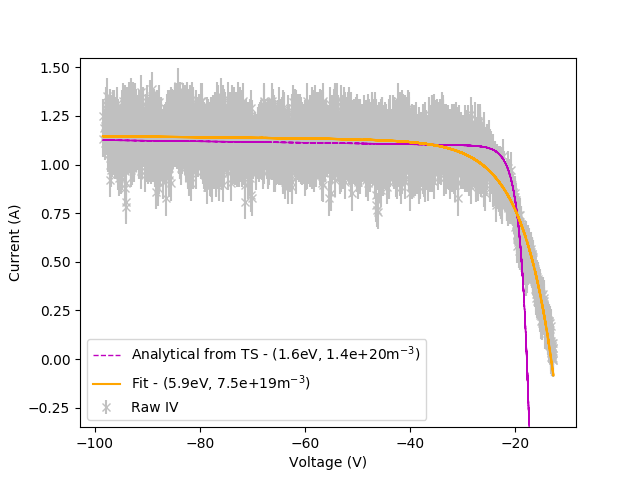

iv = 2: 
	 v_f = -13.2 +- 0.05 
	 T_e = 5.78 +- 0.1 
	 I_sat = 1.07 +- 0.006 
	 n_e = 7.29e+19 +- 5e+18 
	 a = 0.0115 +- 0.001 
	 c_s = 3.33e+04 +- 3e+02 
	 A_coll = 2.75e-06 +- 2e-07 

a = 0.004353069382686505, c_s = 33282.03701432297, lambda_d = 2.094196481259115e-06, I_0 = 1.0679121741870814
a = 0.00165323075130103, c_s = 17582.941645962666, lambda_d = 7.953445529387089e-07, I_0 = 1.0917034253527582


<IPython.core.display.Javascript object>


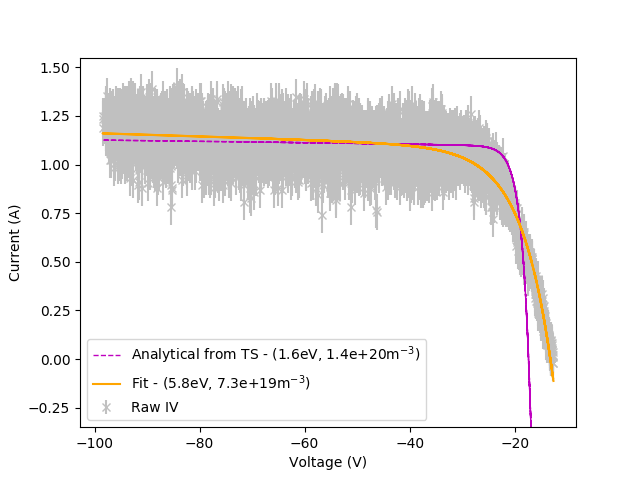

In [8]:
##################################################
#         Examination of 3 different IVs         #
##################################################

for i, iv_data in enumerate(iv_datas):
    # Extract individual values from dataframe
    v_f_fitted = iv_data[c.FLOAT_POT].values[0]
    T_e_fitted = iv_data[c.ELEC_TEMP].values[0]
    a_fitted = iv_data[c.SHEATH_EXP].values[0]
    I_sat_fitted = iv_data[c.ION_SAT].values[0]

    d_v_f_fitted = iv_data[c.ERROR_STRING.format(c.FLOAT_POT)].values[0]
    d_T_e_fitted = iv_data[c.ERROR_STRING.format(c.ELEC_TEMP)].values[0]
    d_a_fitted = iv_data[c.ERROR_STRING.format(c.SHEATH_EXP)].values[0]
    d_I_sat_fitted = iv_data[c.ERROR_STRING.format(c.ION_SAT)].values[0]

    v_f_approx = - 3 * T_e_fitted
    d_v_f_approx = 0.05 * v_f_approx

    c_s_fitted = lp.sound_speed(T_e_fitted, gamma_i=1)
    d_c_s_fitted = lp.d_sound_speed(c_s_fitted, T_e_fitted, d_T_e_fitted)
    n_e_fitted = lp.electron_density(I_sat_fitted, c_s_fitted, A_coll_0)
    d_n_e_fitted = lp.d_electron_density(n_e_fitted, c_s_fitted, d_c_s_fitted, A_coll_0, d_A_coll, I_sat_fitted,
                                         d_I_sat_fitted)

    print('iv = {}: \n'
          '\t v_f = {:.3g} +- {:.1g} \n'
          '\t T_e = {:.3g} +- {:.1g} \n'
          '\t I_sat = {:.3g} +- {:.1g} \n'
          '\t n_e = {:.3g} +- {:.1g} \n'
          '\t a = {:.3g} +- {:.1g} \n'
          '\t c_s = {:.3g} +- {:.1g} \n'
          '\t A_coll = {:.3g} +- {:.1g} \n'
          .format(i, v_f_fitted, d_v_f_fitted, T_e_fitted, d_T_e_fitted, I_sat_fitted, d_I_sat_fitted, n_e_fitted,
                  d_n_e_fitted, a_fitted, d_a_fitted, c_s_fitted, d_c_s_fitted, A_coll_0, d_A_coll))

    I_f = probe_0.get_analytical_iv(iv_data[c.RAW_X].tolist()[0], v_f_fitted, theta_perp, T_e_fitted, n_e_fitted,
                                    print_fl=True)
    I_ts = probe_0.get_analytical_iv(iv_data[c.RAW_X].tolist()[0], v_f_approx, theta_perp, T_e_ts, n_e_ts,
                                     print_fl=True)
    plt.figure()
    plt.errorbar(iv_data[c.RAW_X].tolist()[0], iv_data[c.RAW_Y].tolist()[0], yerr=iv_data[c.SIGMA].tolist()[0],
                 fmt='x', label='Raw IV', ecolor='silver', color='silver', zorder=-1)
    # plt.plot(iv_data[c.RAW_X].tolist()[0], I_f, label='Analytical - measured', linestyle='dashed', linewidth=1, color='r')
    plt.plot(iv_data[c.RAW_X].tolist()[0], I_ts, linestyle='dashed', linewidth=1, color='m',
             label='Analytical from TS - ({:.2g}eV, {:.2g}m'.format(T_e_ts, n_e_ts)+'$^{-3}$)')
    plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.FIT_Y].tolist()[0], color='orange',
             label='Fit - ({:.2g}eV, {:.2g}m'.format(T_e_fitted, n_e_fitted)+r'$^{-3}$)')
    plt.legend()
    # plt.title('Comparison of analytical to measured IV curves for the small area probe')
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.ylim([-0.35, 1.55])
plt.show()

In [13]:
iv_data = magopter.iv_arrs[0][0]

# Find small region of interest
array_length = len(iv_data['I'])
lower_bound = int(0.3 * array_length)
upper_bound = int(0.4 * array_length)
roi = list(range(lower_bound, upper_bound))

print(array_length)
print(lower_bound, upper_bound)

5000
1500 2000


<IPython.core.display.Javascript object>


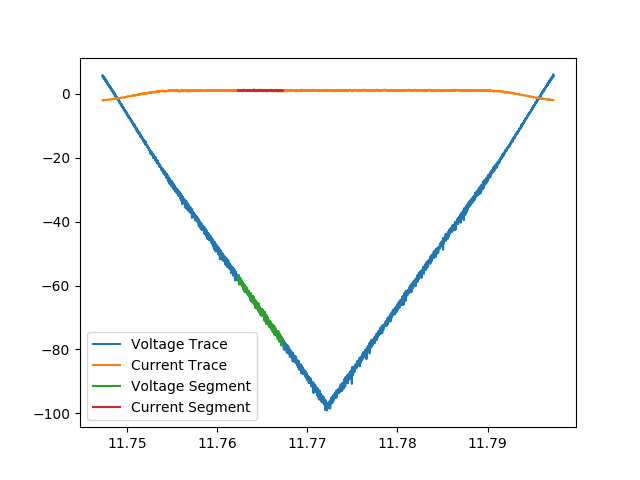

In [14]:
plt.figure()
plt.plot(iv_data['t'], iv_data['V'], label='Voltage Trace')
plt.plot(iv_data['t'], iv_data['I'], label='Current Trace')
plt.plot(iv_data['t'][roi], iv_data['V'][roi], label='Voltage Segment')
plt.plot(iv_data['t'][roi], iv_data['I'][roi], label='Current Segment')
plt.legend()

<IPython.core.display.Javascript object>


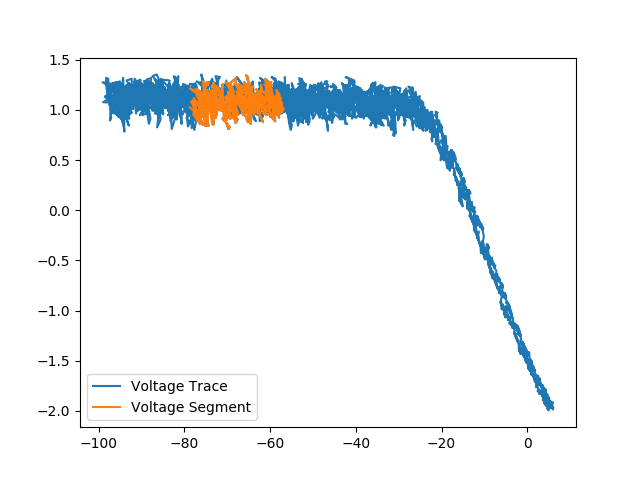

In [33]:
plt.figure()
plt.plot(iv_data['V'], iv_data['I'], label='Voltage Trace')
plt.plot(iv_data['V'][roi], iv_data['I'][roi], label='Voltage Segment')
plt.legend()

In [15]:
half_index = int(array_length * 0.5)
print(half_index)
down_sweep = ivd.IVData.positional_trim(iv_data, 0, half_index)
up_sweep = ivd.IVData.positional_trim(iv_data, half_index, array_length)

print(len(up_sweep['I']), len(down_sweep['I']))

2500
2500 2500


<IPython.core.display.Javascript object>


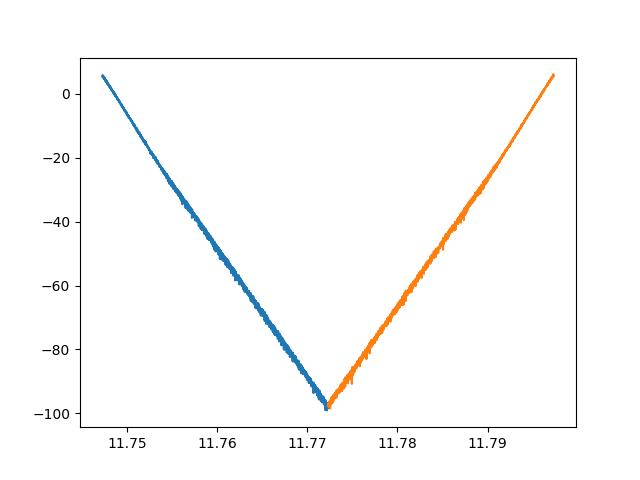

<IPython.core.display.Javascript object>


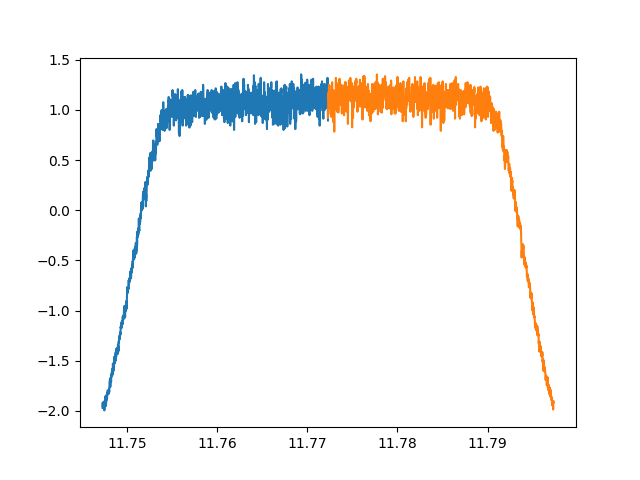

In [17]:
plt.figure()
plt.plot(down_sweep['t'], down_sweep['V'])
plt.plot(up_sweep['t'], up_sweep['V'])

plt.figure()
plt.plot(down_sweep['t'], down_sweep['I'])
plt.plot(up_sweep['t'], up_sweep['I'])

<IPython.core.display.Javascript object>


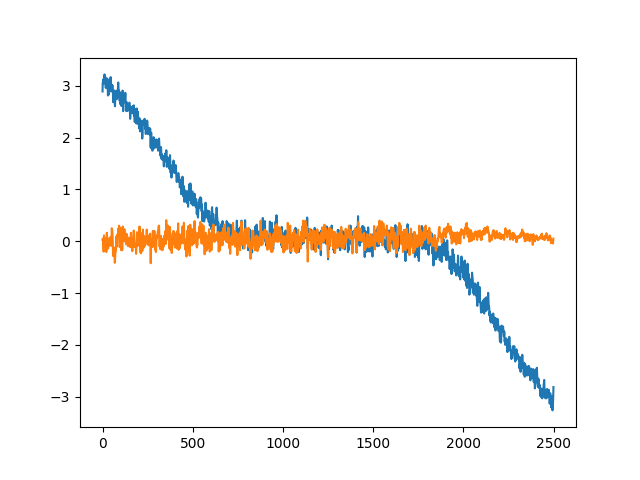

In [16]:
down_sweep_r = down_sweep.copy()
for key, value in down_sweep_r.items():
    down_sweep_r[key] = np.flip(value)

plt.figure()
plt.plot(up_sweep['I'] - down_sweep['I'])

plt.plot(up_sweep['I'] - down_sweep_r['I'])

In [18]:
# Find small region of interest
ind_sweep_length = len(up_sweep['I'])
ind_lower_bound = int(0.01 * ind_sweep_length)
ind_upper_bound = int(0.6 * ind_sweep_length)
roi = list(range(ind_lower_bound, ind_upper_bound))

print(ind_sweep_length)
print(ind_lower_bound, ind_upper_bound)

2500
25 1500


<IPython.core.display.Javascript object>


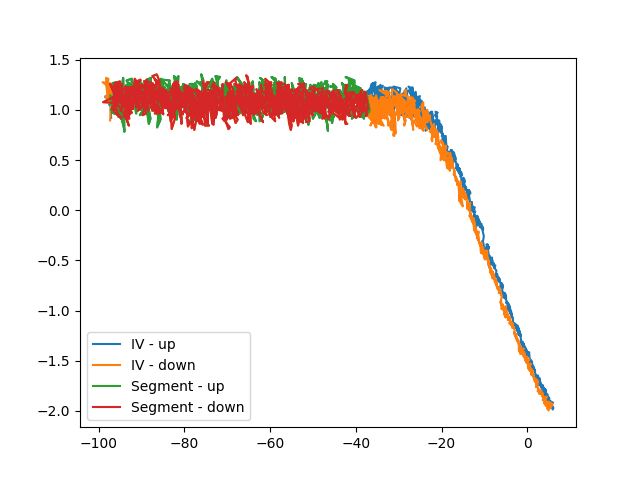

<IPython.core.display.Javascript object>


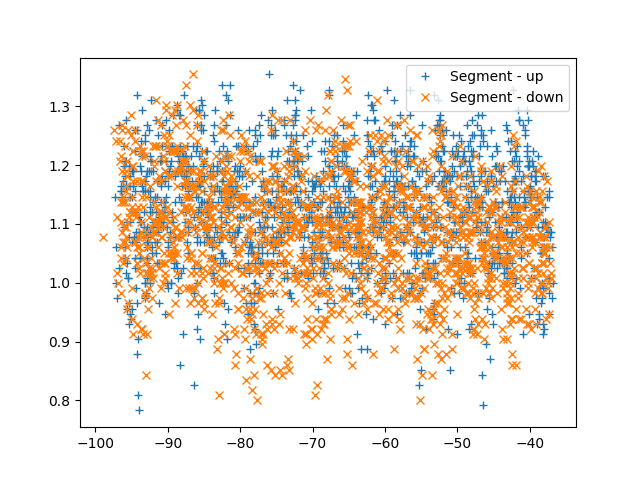

In [19]:
plt.figure()
plt.plot(up_sweep['V'], up_sweep['I'], label='IV - up')
plt.plot(down_sweep_r['V'], down_sweep_r['I'], label='IV - down')
plt.plot(up_sweep['V'][roi], up_sweep['I'][roi], label='Segment - up')
plt.plot(down_sweep_r['V'][roi], down_sweep_r['I'][roi], label='Segment - down')
plt.legend()

plt.figure()
plt.plot(up_sweep['V'][roi], up_sweep['I'][roi], '+', label='Segment - up')
plt.plot(down_sweep_r['V'][roi], down_sweep_r['I'][roi], 'x', label='Segment - down')
plt.legend()

In [21]:
t_up_roi = up_sweep['t'][roi] - up_sweep['t'][ind_lower_bound]
t_down_roi = down_sweep['t'][roi] - down_sweep['t'][ind_lower_bound]

<IPython.core.display.Javascript object>


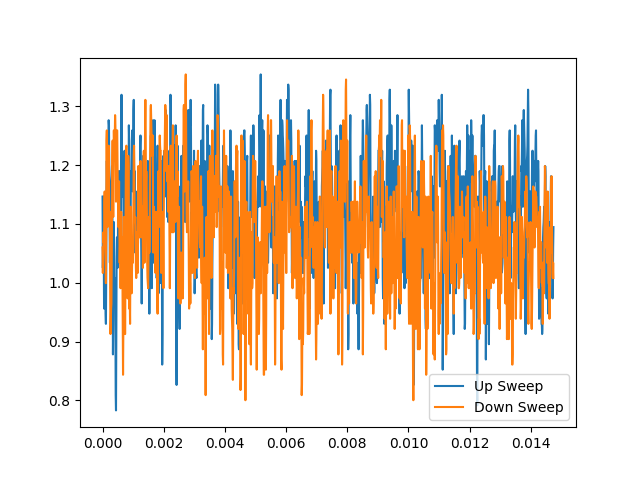

<IPython.core.display.Javascript object>


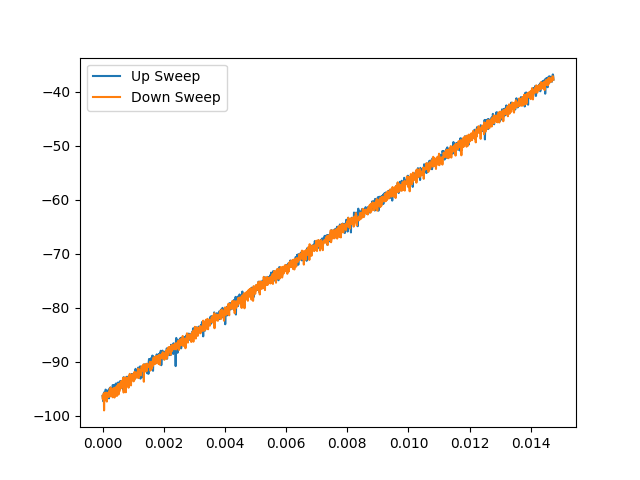

In [22]:
plt.figure()
plt.plot(t_up_roi, up_sweep['I'][roi], label='Up Sweep')
plt.plot(t_down_roi, down_sweep_r['I'][roi], label='Down Sweep')
plt.legend()

plt.figure()
plt.plot(t_up_roi, up_sweep['V'][roi], label='Up Sweep')
plt.plot(t_down_roi, down_sweep_r['V'][roi], label='Down Sweep')
plt.legend()

<IPython.core.display.Javascript object>


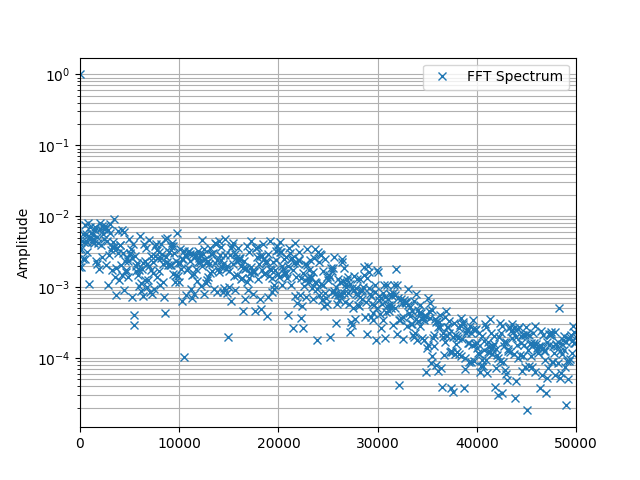

<IPython.core.display.Javascript object>


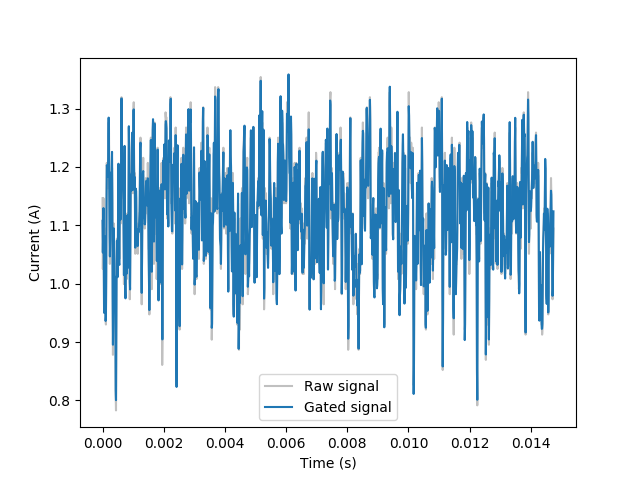

/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [35]:
crit_ampl = 1e-3
time_series = t_up_roi
data = up_sweep['I'][roi]

# gated_filter = filt.GatedFilter(crit_ampl)
# gated_data = gated_filter.apply(t_up_roi, up_sweep['V'][roi], plot_fl=True)

spectrum = np.fft.fft(data)
freq = np.fft.fftfreq(len(data), time_series[1] - time_series[0])
amplitudes = np.abs(spectrum) / np.max(np.abs(spectrum))
sp_gated = spectrum.copy()
for i, amp in enumerate(amplitudes):
    if amp < crit_ampl:
        sp_gated[i] = 0

# Apply gate filter to data
gated_data = np.fft.ifft(sp_gated)

# Plots of the gated spectrum, i.e. frequencies with an amplitude below a certain cutoff are rejected.
plt.figure()
# plt.subplot(211)
plt.semilogy(freq, np.abs(spectrum) / np.max(np.abs(spectrum)), 'x', label='FFT Spectrum')
# plt.axhline(y=crit_ampl, linewidth=1.0, linestyle='dotted', color='red')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')
plt.xlim(0, 50000)
# plt.ylim(1e-6, 1)
plt.legend()

# # plt.subplot(212)
# plt.semilogy(freq, np.abs(sp_gated) / np.max(np.abs(sp_gated)), 'x', label='Gated Spectrum')
# plt.axhline(y=crit_ampl, linewidth=1.0, linestyle='dotted', color='red')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.grid(which='both', axis='both')
# plt.xlim(0, 50000)
# # plt.ylim(1e-6, 1)
# plt.legend()

# Plot of inverse-fft'd gated spectrum compared to the raw_signal
plt.figure()
plt.plot(time_series, data, label='Raw signal', color='silver')
plt.plot(time_series, gated_data, label='Gated signal')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()

plt.show()

f_crit = 2000, f_nyq = 49999.97499968287, f_crit_hat = 0.0400000200002637


<IPython.core.display.Javascript object>


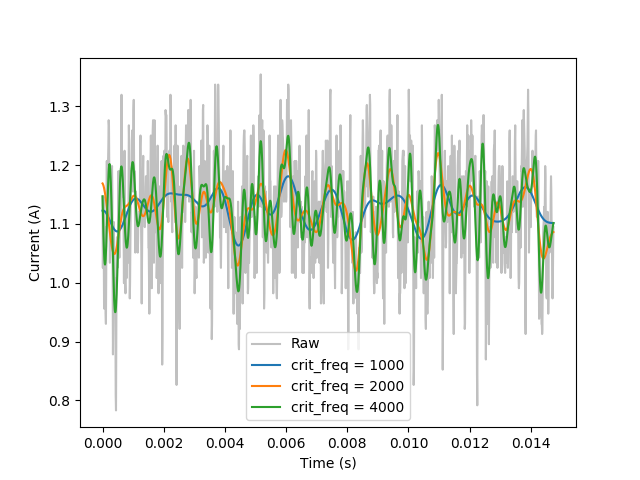

/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Text(0,0.5,'Current (A)')

In [25]:
crit_freq = 2000
low_pass = filt.LowPassFilter(crit_freq)
nyq = 1 / (2 * (t_up_roi[1] - t_up_roi[0]))
crit_freq_norm = crit_freq / nyq

print('f_crit = {}, f_nyq = {}, f_crit_hat = {}'.format(crit_freq, nyq, crit_freq_norm))

plt.figure()
plt.plot(t_up_roi, up_sweep['I'][roi], color='silver', label='Raw')
for cf in [0.5, 1, 2]:
    bb, aa = sig.butter(6, cf * crit_freq_norm, analog=False)
    ff_current = sig.filtfilt(bb, aa, up_sweep['I'][roi])
    plt.plot(t_up_roi, ff_current, label='crit_freq = {:.0f}'.format(cf * crit_freq_norm * nyq))
plt.legend()
# plt.xlim(12, 12.5)
# plt.ylim(-2.25, 1.35)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')

**Semi-log plot of IV characteristic**

-13.509796185623705


<IPython.core.display.Javascript object>


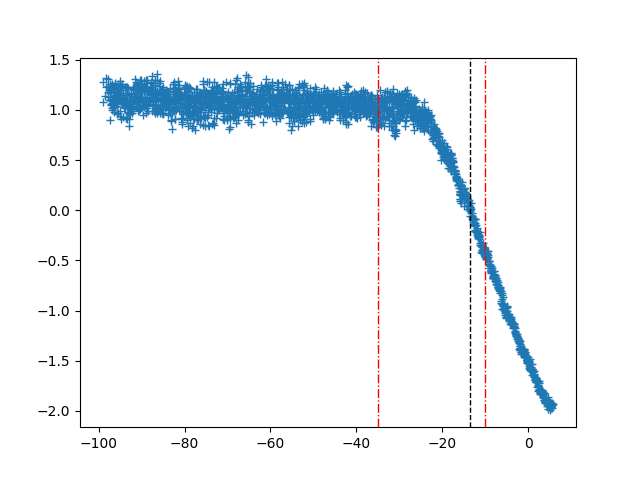

<IPython.core.display.Javascript object>


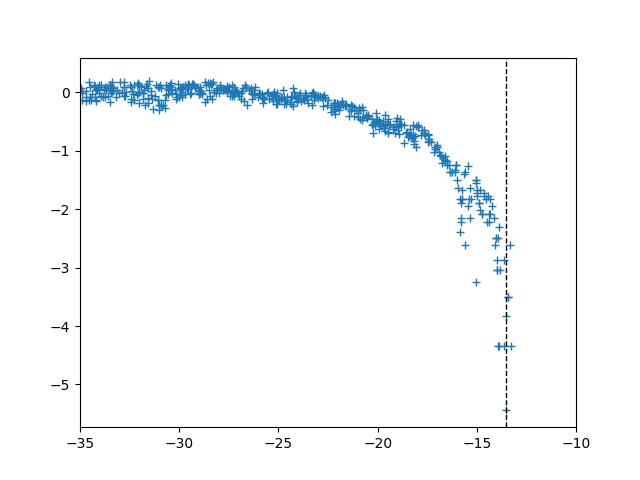

(-35, -10)

In [32]:
logging_data_x = down_sweep_r['V']
logging_data_y = down_sweep_r['I']

indices = logging_data_y >= 0
v_f_approx = logging_data_x[np.argmin(np.abs(logging_data_y))]
print(v_f_approx)

plt.figure()
plt.plot(logging_data_x, logging_data_y, '+')
plt.axvline(x=v_f_approx, color='k', linestyle='--', linewidth=1)
plt.axvline(x=-35, color='r', linestyle='-.', linewidth=1)
plt.axvline(x=-10, color='r', linestyle='-.', linewidth=1)

plt.figure()
plt.plot(logging_data_x[indices], np.log(logging_data_y[indices]), '+')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=v_f_approx, color='k', linestyle='--', linewidth=1)

# plt.ylim(1e-20,3)
plt.xlim(-35, - 10)

<IPython.core.display.Javascript object>


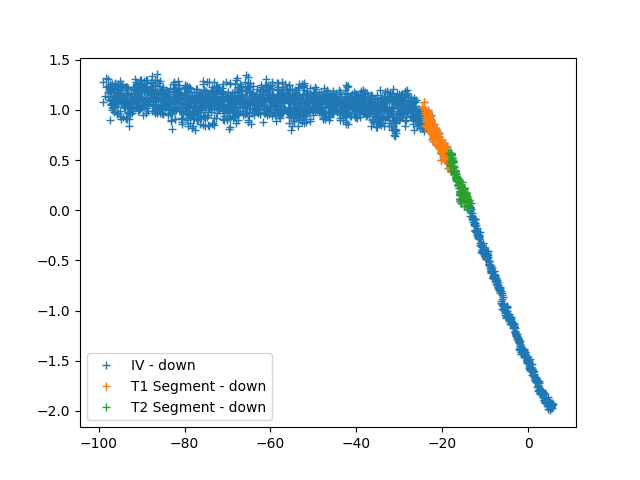

<IPython.core.display.Javascript object>


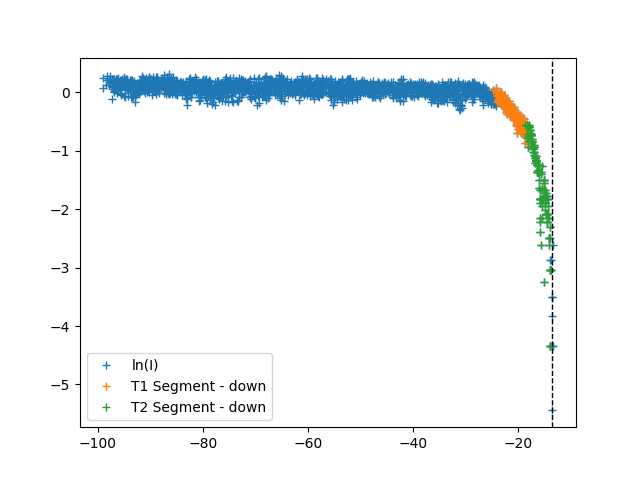

<IPython.core.display.Javascript object>


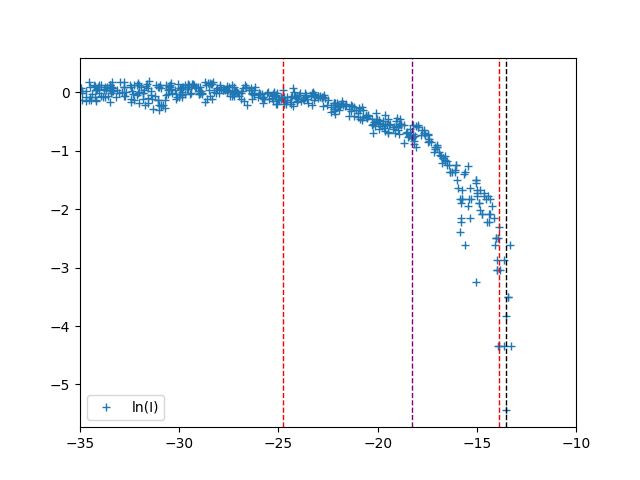

(-35, -10)

In [33]:
# Find small separate temperature regions to do a linear fit to
t1_lbound = int(0.73 * ind_sweep_length)
t1_ubound = int(0.785 * ind_sweep_length)
t2_lbound = int(0.785 * ind_sweep_length)
t2_ubound = int(0.825 * ind_sweep_length)
t1_roi = list(range(t1_lbound, t1_ubound))
t2_roi = list(range(t2_lbound, t2_ubound))

plt.figure()
plt.plot(logging_data_x, logging_data_y, '+', label='IV - down')
plt.plot(logging_data_x[t1_roi], logging_data_y[t1_roi], '+', label='T1 Segment - down')
plt.plot(logging_data_x[t2_roi], logging_data_y[t2_roi], '+', label='T2 Segment - down')
plt.legend()

plt.figure()
plt.plot(logging_data_x[indices], np.log(logging_data_y[indices]), '+', label='ln(I)')
plt.plot(logging_data_x[t1_roi], np.log(logging_data_y[t1_roi]), '+', label='T1 Segment - down')
plt.plot(logging_data_x[t2_roi], np.log(logging_data_y[t2_roi]), '+', label='T2 Segment - down')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=v_f_approx, color='k', linestyle='--', linewidth=1)
plt.legend()

plt.figure()
plt.plot(logging_data_x[indices], np.log(logging_data_y[indices]), '+', label='ln(I)')
plt.axvline(x=logging_data_x[t1_roi[0]], color='r', linestyle='--', linewidth=1)
plt.axvline(x=logging_data_x[t2_roi[0]], color='purple', linestyle='--', linewidth=1)
plt.axvline(x=logging_data_x[t2_roi[-1]], color='r', linestyle='--', linewidth=1)
# plt.plot(logging_data_x[t1_roi], np.log(logging_data_y[t1_roi]), '+', label='T1 Segment - down')
# plt.plot(logging_data_x[t2_roi], np.log(logging_data_y[t2_roi]), '+', label='T2 Segment - down')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=v_f_approx, color='k', linestyle='--', linewidth=1)
plt.legend()

# plt.ylim(1e-20,3)
plt.xlim(-35, - 10)

<IPython.core.display.Javascript object>


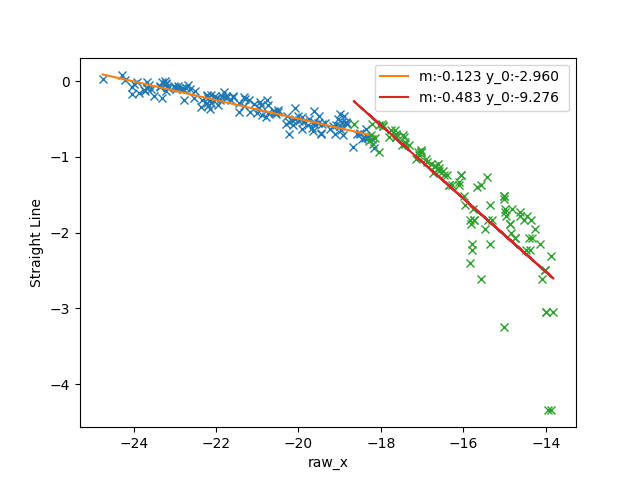

In [34]:
fitter = fts.StraightLineFitter()
fit_data_t1 = fitter.fit(logging_data_x[t1_roi], np.log(logging_data_y[t1_roi]))
fit_data_t2 = fitter.fit(logging_data_x[t2_roi], np.log(logging_data_y[t2_roi]))

fig = plt.figure()
fit_data_t1.plot(fig=fig, show_fl=False)
fit_data_t2.plot(fig=fig)

Running fit with 4 Parameter Fit


<IPython.core.display.Javascript object>


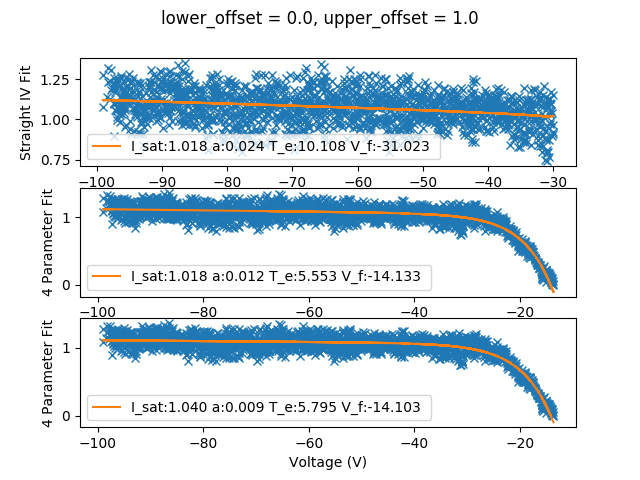

In [167]:
iv_fit_data = down_sweep_r.multi_fit(plot_fl=True, print_fl=True)

In [168]:
print(T_e_ts)

1.6137656341587758


**Time averaged IV characteristic**

In [170]:
magopter_tav = mg.Magopter(folder, file, ts_filename=ts_file)
magopter_tav.prepare(down_sampling_rate=dsr, roi_b_plasma=True, plot_fl=False, crit_freq=None, crit_ampl=None)

Ice.ConnectionRefusedException:
Connection refused
Database could not be connected to, operating in offline mode.


/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


peaks_len = 798


NameError: name 'magopter_tac' is not defined

In [181]:
print(len(magopter_tav.iv_arrs[0]))
iv_arrs = magopter_tav.iv_arrs[0]

for i, iv in enumerate(iv_arrs):
    l = len(iv['t'])
    if l != 5000:
        print(i, l)

# print(relative_t)
print(np.shape(relative_t))
        
relative_t = np.zeros([len(iv_arrs), len(iv_arrs[0]['t'])])
for i, iv in enumerate(iv_arrs):
    relative_t[i] = iv['t'] - iv['t'][0]




798
398 4999
399 4999
[[0.0000000e+00 1.0000005e-05 2.0000010e-05 ... 4.9970025e-02
  4.9980025e-02 4.9990025e-02]
 [0.0000000e+00 1.0000005e-05 2.0000010e-05 ... 4.9970025e-02
  4.9980025e-02 4.9990025e-02]
 [0.0000000e+00 1.0000005e-05 2.0000010e-05 ... 4.9970025e-02
  4.9980025e-02 4.9990025e-02]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
(798, 5000)


ValueError: could not broadcast input array from shape (4999) into shape (5000)

<IPython.core.display.Javascript object>


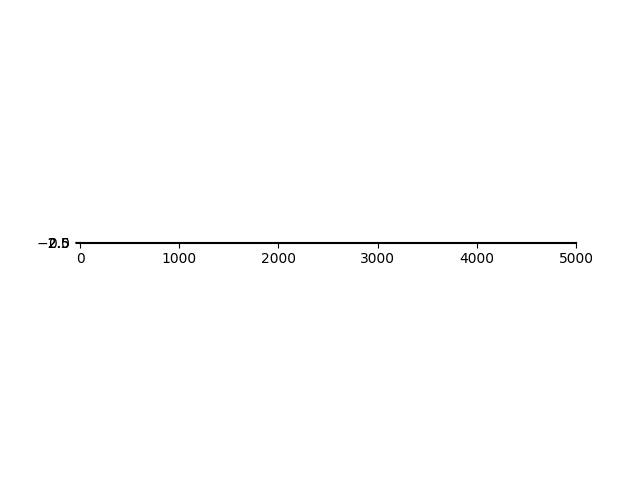

In [176]:
plt.figure()
plt.imshow(relative_t)